In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys  
from pathlib import Path

ROOT = Path.cwd().parent
sys.path.insert(0, str(ROOT))

#Archivos propios
import src.models as models
import src.preprocessing as pre
import src.metrics as metrics


In [9]:

# Paths a los datasets (ajusta si cambia la ruta)
path_imb_dev = "C:\\Users\\Lucas\\OneDrive\\Escritorio\\UdeSA\\2025\\Segundo Cuatrimestre\\Aprendizaje Automatico y Profundo\\Machine-Learning\\Machine-Learning\\TP2-Clasificacion-Multiclase\\I302_ML_TP02_Ejercicio 1\\Ejercicio 1\\data\\raw\\cell_diagnosis_imbalanced_dev.csv"
path_imb_test = "C:\\Users\\Lucas\\OneDrive\\Escritorio\\UdeSA\\2025\\Segundo Cuatrimestre\\Aprendizaje Automatico y Profundo\\Machine-Learning\\Machine-Learning\\TP2-Clasificacion-Multiclase\\I302_ML_TP02_Ejercicio 1\\Ejercicio 1\\data\\raw\\cell_diagnosis_imbalanced_test.csv"
path_bal_dev = "C:\\Users\\Lucas\\OneDrive\\Escritorio\\UdeSA\\2025\\Segundo Cuatrimestre\\Aprendizaje Automatico y Profundo\\Machine-Learning\\Machine-Learning\\TP2-Clasificacion-Multiclase\\I302_ML_TP02_Ejercicio 1\\Ejercicio 1\\data\\raw\\cell_diagnosis_balanced_dev.csv"
path_bal_test = "C:\\Users\\Lucas\\OneDrive\\Escritorio\\UdeSA\\2025\\Segundo Cuatrimestre\\Aprendizaje Automatico y Profundo\\Machine-Learning\\Machine-Learning\\TP2-Clasificacion-Multiclase\\I302_ML_TP02_Ejercicio 1\\Ejercicio 1\\data\\raw\\cell_diagnosis_balanced_test.csv"

# Cargar datasets
imb_dev = pd.read_csv(path_imb_dev)
imb_test = pd.read_csv(path_imb_test)
bal_dev = pd.read_csv(path_bal_dev)
bal_test = pd.read_csv(path_bal_test)

# Ver las primeras filas y shape de cada uno
print("Imbalanced Dev:", imb_dev.shape)
print("Imbalanced Test:", imb_test.shape)
print("Balanced Dev:", bal_dev.shape)
print("Balanced Test:", bal_test.shape)

print("\nEjemplo (imbalanced dev):")
print(imb_dev.head())

Imbalanced Dev: (1218, 15)
Imbalanced Test: (136, 15)
Balanced Dev: (1663, 15)
Balanced Test: (185, 15)

Ejemplo (imbalanced dev):
     CellSize  CellShape  NucleusDensity  ChromatinTexture  CytoplasmSize  \
0   67.663374   0.513293        1.483674               NaN            NaN   
1 -100.000000   0.508854        1.458626               NaN      26.553677   
2   61.101997   0.466692        1.487378         23.033832      26.190955   
3   69.867684   0.519679        1.371829         20.910025      27.896494   
4   65.391094   0.489866        1.574212         19.964398      25.472444   

   CellAdhesion  MitosisRate  NuclearMembrane  GrowthFactor  OxygenSaturation  \
0      0.476990     3.325950         2.449179     58.451676               NaN   
1      0.499220     3.274258         2.567775    -50.000000         79.573324   
2      0.459161          NaN         2.472128     67.187650         78.235757   
3      0.518146     2.736139         2.400920     60.788227         79.562821   
4

In [10]:
print(imb_dev.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CellSize             982 non-null    float64
 1   CellShape            981 non-null    float64
 2   NucleusDensity       998 non-null    float64
 3   ChromatinTexture     1006 non-null   float64
 4   CytoplasmSize        973 non-null    float64
 5   CellAdhesion         1004 non-null   float64
 6   MitosisRate          978 non-null    float64
 7   NuclearMembrane      993 non-null    float64
 8   GrowthFactor         988 non-null    float64
 9   OxygenSaturation     998 non-null    float64
 10  Vascularization      988 non-null    float64
 11  InflammationMarkers  999 non-null    float64
 12  Diagnosis            1218 non-null   float64
 13  CellType             1034 non-null   object 
 14  GeneticMutation      1218 non-null   object 
dtypes: float64(13), object(2)
memory usage

In [11]:
# Divido el set de dev en train y
train_df, test_df = pre.split_train_val(imb_dev)

# Eliminar filas con datos faltantes en la columna "Diagnosis" de todos los datasets
train_df = train_df.dropna(subset=["Diagnosis"])
test_df = test_df.dropna(subset=["Diagnosis"])

# Completo los NaNs de las columnas categóricas con la moda de cada columna
train_df = pre.add_missing_values_mode(train_df, ["CellType", "GeneticMutation"])
test_df = pre.add_missing_values_mode(test_df, ["CellType", "GeneticMutation"])

# One-Hot Encoding de las variables categóricas "CellType" y "GeneticMutation"
train_df = pd.get_dummies(train_df, columns=["CellType", "GeneticMutation"], drop_first=True)
test_df = pd.get_dummies(test_df, columns=["CellType", "GeneticMutation"], drop_first=True)

# Normalizo usando mu y sigma del set de test para evitar data leakage
train_df, test_df, mu , sigma = pre.normalize(train_df, test_df, target_name="Diagnosis")

# Completo los NaNs de las columnas numéricas usando KNN
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.drop("Diagnosis")

train_df = pre.handle_missing_values(train_df, numeric_cols, method='knn')
test_df = pre.handle_missing_values(test_df, numeric_cols, method='knn')

print(train_df.info())




<class 'pandas.core.frame.DataFrame'>
Index: 974 entries, 541 to 800
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CellSize                974 non-null    float64
 1   CellShape               974 non-null    float64
 2   NucleusDensity          974 non-null    float64
 3   ChromatinTexture        974 non-null    float64
 4   CytoplasmSize           974 non-null    float64
 5   CellAdhesion            974 non-null    float64
 6   MitosisRate             974 non-null    float64
 7   NuclearMembrane         974 non-null    float64
 8   GrowthFactor            974 non-null    float64
 9   OxygenSaturation        974 non-null    float64
 10  Vascularization         974 non-null    float64
 11  InflammationMarkers     974 non-null    float64
 12  Diagnosis               974 non-null    float64
 13  CellType_Epthlial       974 non-null    bool   
 14  CellType_Mesnchymal     974 non-null    bool 

In [12]:
# Hacer scatter plots de las columnas para comparar todas con todas, coloreando por Diagnosis
#palette = {0: "red", 1: "green"}
#sns.pairplot(train_df, hue="Diagnosis", palette=palette)
#plt.suptitle('Comparación entre todas las variables (Imbalanced Dev)', y=1.02)
#plt.show()

c:\Users\Lucas\OneDrive\Escritorio\UdeSA\2025\Segundo Cuatrimestre\Aprendizaje Automatico y Profundo\Machine-Learning\Machine-Learning\TP2-Clasificacion-Multiclase\I302_ML_TP02_Ejercicio 1\Ejercicio 1\src\models.py:31: RuntimeWarning: overflow encountered in matmul
  z = X @ self.weights + self.bias
c:\Users\Lucas\OneDrive\Escritorio\UdeSA\2025\Segundo Cuatrimestre\Aprendizaje Automatico y Profundo\Machine-Learning\Machine-Learning\TP2-Clasificacion-Multiclase\I302_ML_TP02_Ejercicio 1\Ejercicio 1\src\models.py:38: RuntimeWarning: overflow encountered in multiply
  self.weights = (1.0 - self.learning_rate * self.L2) * self.weights - self.learning_rate * grad_w
c:\Users\Lucas\OneDrive\Escritorio\UdeSA\2025\Segundo Cuatrimestre\Aprendizaje Automatico y Profundo\Machine-Learning\Machine-Learning\TP2-Clasificacion-Multiclase\I302_ML_TP02_Ejercicio 1\Ejercicio 1\src\models.py:31: RuntimeWarning: invalid value encountered in matmul
  z = X @ self.weights + self.bias


Best lambda: 0.08858667904100823, Best F1-score (weighted): 0.665037


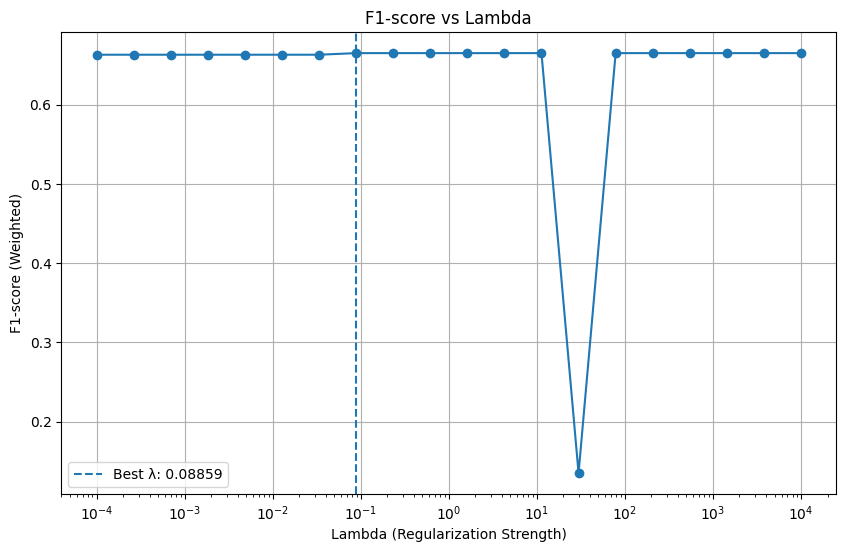

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Helpers ----------
def _ensure_float_matrix(X):
    # coerciona a float64 sin romper si viene de pandas
    return np.asarray(X, dtype=np.float64)

def _ensure_labels_array(y):
    # deja y como array (no fuerza a 0/1 porque puede ser multiclase)
    return np.asarray(y)

def _weighted_f1_from_dict(f1_dict, y_true, labels):
    # weighted por soporte real de y_true
    return float(sum(f1_dict[label] * np.sum(y_true == label) for label in labels) / len(y_true))

# ---------- Datos ----------
X_train = _ensure_float_matrix(train_df.drop(columns=["Diagnosis"]).values)
y_train = _ensure_labels_array(train_df["Diagnosis"].values)
X_val   = _ensure_float_matrix(test_df.drop(columns=["Diagnosis"]).values)
y_val   = _ensure_labels_array(test_df["Diagnosis"].values)

labels = np.unique(y_train)
n_classes = len(labels)

# ---------- Barrido de lambdas ----------
lambdas = np.logspace(-4, 4, 20)
best_lambda = None
best_f1 = -1.0
best_model = None         # binario: instancia; multiclase: dict {label: modelo}
f1_scores = []

# Tip: bajar un poco el lr para evitar overflows con lambdas grandes
LEARNING_RATE = 0.1
N_ITER = 1000

for L2 in lambdas:
    if n_classes == 2:
        # --- Caso binario ---
        model = models.LogisticRegressionL2(L2=L2, learning_rate=LEARNING_RATE, n_iter=N_ITER)
        model.fit(X_train, (y_train == labels[1]).astype(float))  # map a {0,1} respecto a la clase positiva
        y_val_pred = model.predict(X_val)                         # 0/1
        # Volvemos a etiquetas originales para métricas
        y_val_pred_labels = np.where(y_val_pred == 1, labels[1], labels[0])
        f1_dict = metrics.f1_score(y_val, y_val_pred_labels, labels)
        f1_w = _weighted_f1_from_dict(f1_dict, y_val, labels)
        f1_scores.append(f1_w)
        if f1_w > best_f1:
            best_f1 = f1_w
            best_lambda = L2
            best_model = model
        # logging opcional
        # print("lambda =", L2, "weights norm =", np.linalg.norm(model.weights))

    else:
        # --- Caso multiclase (OvR/A&A): entrenamos un modelo por clase ---
        models_ovr = {}
        # Probabilidades por clase para el set de validación
        proba_val = np.zeros((len(X_val), n_classes), dtype=np.float64)

        for j, cls in enumerate(labels):
            y_train_bin = (y_train == cls).astype(float)
            m = models.LogisticRegressionL2(L2=L2, learning_rate=LEARNING_RATE, n_iter=N_ITER)
            m.fit(X_train, y_train_bin)
            models_ovr[cls] = m
            proba_val[:, j] = m.predict_proba(X_val)  # prob de "ser esa clase" vs resto

        # predicción = argmax de probabilidades OvR
        idx_max = np.argmax(proba_val, axis=1)
        y_val_pred_labels = labels[idx_max]

        f1_dict = metrics.f1_score(y_val, y_val_pred_labels, labels)
        f1_w = _weighted_f1_from_dict(f1_dict, y_val, labels)
        f1_scores.append(f1_w)
        if f1_w > best_f1:
            best_f1 = f1_w
            best_lambda = L2
            best_model = models_ovr
        # logging opcional: norma promedio
        # mean_norm = np.mean([np.linalg.norm(m.weights) for m in models_ovr.values()])
        # print("lambda =", L2, "mean weights norm =", mean_norm)

print(f"Best lambda: {best_lambda}, Best F1-score (weighted): {best_f1:.6f}")

# ---------- Gráfico F1-score vs lambda ----------
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, f1_scores, marker='o')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('F1-score (Weighted)')
plt.title('F1-score vs Lambda')
plt.grid(True)
plt.axvline(best_lambda, linestyle='--', label=f'Best λ: {best_lambda:.4g}')
plt.legend()
plt.show()


Reportar las siguientes métricas:
– Matriz de confusión
– Accuracy
– Precision
– Recall
– F1-Score
– Curva Precision-Recall (PR)
– Curva ROC
– AUC-ROC
– AUC-PR